In [1]:
import numpy as np
import pandas as pd
import os
from torch.utils.data import Dataset
import cv2
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import itertools
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer,VisImage
from detectron2 import model_zoo
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader,build_detection_train_loader
from detectron2.evaluation import COCOEvaluator, DatasetEvaluators, verify_results
import detectron2.data.transforms as T
from detectron2.data import detection_utils as utils
from detectron2.data import DatasetMapper
from detectron2.utils.visualizer import ColorMode
from detectron2.structures import BoxMode
import copy
import torch
import warnings
from PIL import ImageFile
import itertools
import os
import numpy as np
import seaborn as sns
from bounding_box import bounding_box as bb # https://github.com/nalepae/bounding-box

#### Dataset foraminifères

In [2]:
import os
import xml.etree.ElementTree as ET
from torch.utils.data import Dataset, DataLoader

class VOCDataset(Dataset):
    def __init__(self, root_path="YOURI", mode="train"):
        
        
        if (mode in ["train", "val", "trainval", "test"]):
            self.data_path = root_path
        id_list_path = os.path.join(self.data_path, "Foraminiferas-PascalVOC-export/ImageSets/Main/{}.txt".format(mode))
        liste1 = [id.strip("\n") for id in open(id_list_path)]
        liste1=[id[:-6] for id in liste1]
        self.ids = liste1
        self.classes = ['alveolina','assilina','coral','echinoderms','gasteropods','miliolids', 'nummulites',
 'orbitolites','red algae']
        #self.classes = ['Alveolina', 'Miliolids', 'Orbitolites', 'Nummulites', 'Gasteropods', 'Coral', 'Red algae', 'Echinoderms', 'Assilina']
        self.num_classes = len(self.classes)
        self.num_images = len(self.ids)

    def __len__(self):
        return self.num_images
   
    def __getitem__(self, item):
        id = self.ids[item]
        image_path = os.path.join(self.data_path, "Scan-Lames", "{}.jpg".format(id))
        if not os.path.isfile(image_path):
            
            image_path = os.path.join(self.data_path, "Scan-Lames", "{}.JPG".format(id))
        if not os.path.isfile(image_path):
            image_path = os.path.join(self.data_path, "Scan-Lames", "{}.png".format(id))
            
            
        #print(image_path)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        height=image.shape[0]
        width=image.shape[1]
        image_xml_path = os.path.join(self.data_path, "Foraminiferas-PascalVOC-export/Annotations", "{}.xml".format(id))
        annot = ET.parse(image_xml_path)
        objects = []
        dicts={}
        dicts["filename"]=image_path
        dicts["height"]=height
        dicts["width"]=width
        dicts["image_id"]=id
        dicts["image"]=image
        for obj in annot.findall('object'):
            xmin, xmax, ymin, ymax = [float(obj.find('bndbox').find(tag).text) - 1 for tag in
                                      ["xmin", "xmax", "ymin", "ymax"]]
            label = self.classes.index(obj.find('name').text.lower().strip())
            objects.append([xmin, ymin, xmax, ymax, label])
        
        dicts["annotations"]=np.array(objects)
        
        return dicts

In [3]:
training_set = VOCDataset(root_path='YOURI', mode='train')
test_set = VOCDataset('YOURI', 'val')
print(len(training_set))
print(len(test_set))

15
15


In [4]:
colors=["navy", "blue", "aqua", "teal", "olive", "green", "lime", "yellow", "orange", "red", "maroon", "fuchsia", 
        "purple", "black", "gray" ,"silver"]


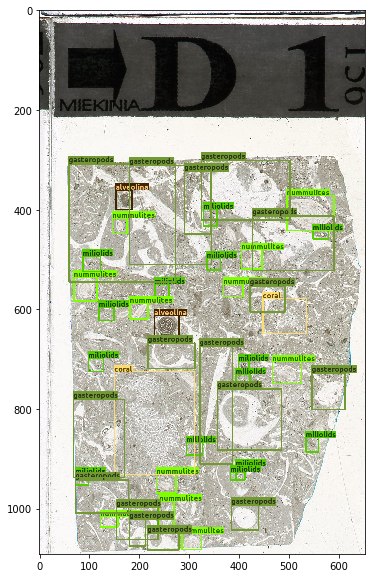

In [5]:
item=np.random.choice(len(test_set),1,replace=False)
dicts=test_set[item[0]]
image=dicts["image"]
label=dicts["annotations"]
fig,ax=plt.subplots(figsize=(10,10))
for i in range(len(label)):
    data=label[i]
    xmin,ymin,xmax,ymax=data[0],data[1],data[2],data[3]
    bb.add(image=image, left=xmin, top=ymin, right=xmax, bottom=ymax, label=training_set.classes[int(data[4])], color=colors[int(data[4])])
ax.imshow(image.astype('uint8'))

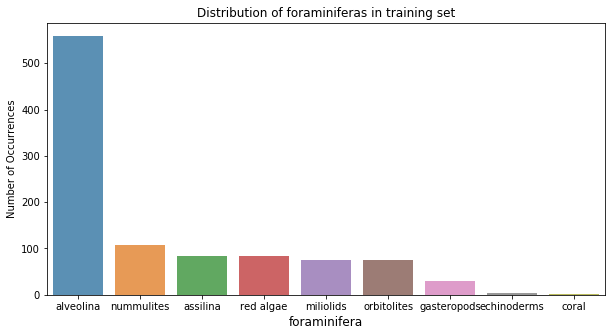

In [6]:
repartitions=[]
n_bins=10
for item in range(len(training_set)):
    dicts=training_set[item]
    label=dicts["annotations"]
    for i in range(len(label)):
        data=label[i]
        classe=int(data[4])
        repartitions.append(training_set.classes[classe])
df=pd.DataFrame(data={"classes":repartitions})
classe_count  = df['classes'].value_counts()
classe_count = classe_count[:10,]
plt.figure(figsize=(10,5))
sns.barplot(classe_count.index, classe_count.values, alpha=0.8)
plt.title('Distribution of foraminiferas in training set')
plt.ylabel('Number of Occurrences', fontsize=10)
plt.xlabel('foraminifera', fontsize=12)
plt.show()

## Detectron2 data format

In [7]:
def get_rock_dicts(mode):
    dataset=VOCDataset('YOURI',mode)
    dataset_dicts = []
    for item in range(len(dataset)):
        data=dataset[item]
        record = {}
        record["file_name"] = data["filename"]
        record["image_id"] = data["image_id"]
        record["height"] = data["height"]
        record["width"] = data["width"]
        annos=data["annotations"]
        objs = []
        for i in range(len(annos)):
            anno=annos[i]
            xmin = int(anno[0])
            ymin = int(anno[1])
            xmax = int(anno[2])
            ymax = int(anno[3])
            label=int(anno[4])

            poly = [
          (xmin, ymin), (xmax, ymin),
          (xmax, ymax), (xmin, ymax)
                                      ]
            poly = list(itertools.chain.from_iterable(poly))
            obj = {
                "bbox": [xmin,ymin,xmax,ymax],
                "bbox_mode": BoxMode.XYXY_ABS,
                 "segmentation": [poly],
                "category_id": label,
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [8]:
from detectron2.data import DatasetCatalog, MetadataCatalog
for d in ["train","val"]:
    DatasetCatalog.register("foraminifera_" + d, lambda d=d: get_rock_dicts(d))
    MetadataCatalog.get("foraminifera_" + d).set(thing_classes=training_set.classes)
rock_metadata = MetadataCatalog.get("foraminifera_train")

In [9]:
dataset_dicts = get_rock_dicts('train')

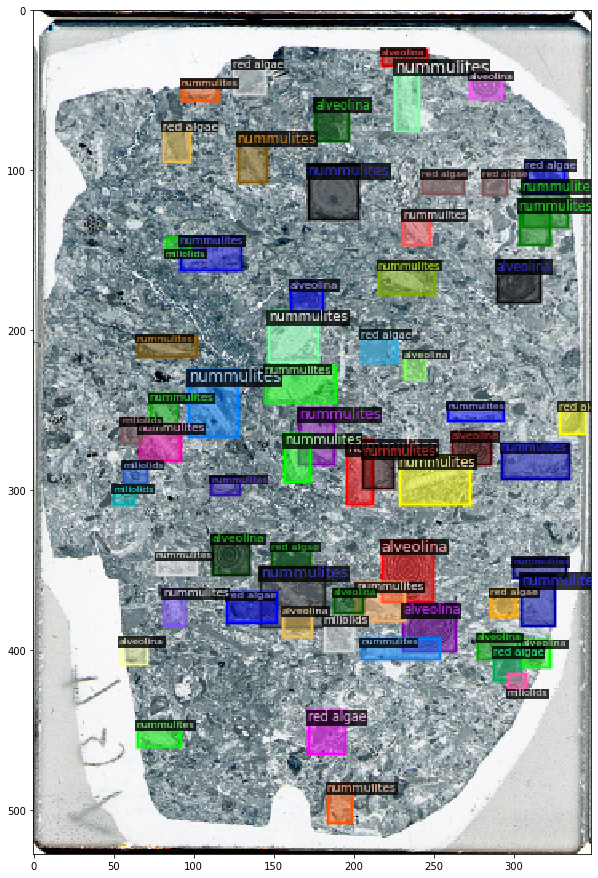

In [10]:
item=np.random.choice(len(dataset_dicts),1,replace=False)
d=dataset_dicts[item[0]]
img = cv2.imread(d["file_name"])
visualizer = Visualizer(img[:, :, ::-1], metadata=rock_metadata, scale=0.5)
vis = visualizer.draw_dataset_dict(d)
fig,ax=plt.subplots(figsize=(10,16))
plt.imshow(vis.get_image()[:, :, ::-1])

# Train

### Custom mapper for data augmentation

In [11]:
class DatasetMapper:
    """
    A callable which takes a dataset dict in Detectron2 Dataset format,
    and map it into a format used by the model.

    This is a custom version of the DatasetMapper. The only different with Detectron2's 
    DatasetMapper is that we extract attributes from our dataset_dict. 
    """

    def __init__(self, cfg, is_train=True):
        if cfg.INPUT.CROP.ENABLED and is_train:
            self.crop_gen = T.RandomCrop(cfg.INPUT.CROP.TYPE, cfg.INPUT.CROP.SIZE)
            logging.getLogger(__name__).info("CropGen used in training: " + str(self.crop_gen))
        else:
            self.crop_gen = None
        
        self.tfm_gens = [T.Resize((800,800)),
                         T.RandomBrightness(0.8, 1.8),
                         T.RandomContrast(0.6, 1.3),
                         T.RandomSaturation(0.8, 1.4),
                         T.RandomRotation(angle=[90, 90]),
                         T.RandomLighting(0.7),
                         T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
                         T.RandomCrop('relative_range', (0.4, 0.6))
                        ]

        # self.tfm_gens = utils.build_transform_gen(cfg, is_train)

        # fmt: off
        self.img_format     = cfg.INPUT.FORMAT
        self.mask_on        = cfg.MODEL.MASK_ON
        self.mask_format    = cfg.INPUT.MASK_FORMAT
        self.keypoint_on    = cfg.MODEL.KEYPOINT_ON
        self.load_proposals = cfg.MODEL.LOAD_PROPOSALS
        # fmt: on
        if self.keypoint_on and is_train:
            # Flip only makes sense in training
            self.keypoint_hflip_indices = utils.create_keypoint_hflip_indices(cfg.DATASETS.TRAIN)
        else:
            self.keypoint_hflip_indices = None

        if self.load_proposals:
            self.min_box_side_len = cfg.MODEL.PROPOSAL_GENERATOR.MIN_SIZE
            self.proposal_topk = (
                cfg.DATASETS.PRECOMPUTED_PROPOSAL_TOPK_TRAIN
                if is_train
                else cfg.DATASETS.PRECOMPUTED_PROPOSAL_TOPK_TEST
            )
        self.is_train = is_train

    def __call__(self, dataset_dict):
        """
        Args:
            dataset_dict (dict): Metadata of one image, in Detectron2 Dataset format.

        Returns:
            dict: a format that builtin models in detectron2 accept
        """
        dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
        # USER: Write your own image loading if it's not from a file
        image = utils.read_image(dataset_dict["file_name"], format=self.img_format)
        utils.check_image_size(dataset_dict, image)

        if "annotations" not in dataset_dict:
            image, transforms = T.apply_transform_gens(
                ([self.crop_gen] if self.crop_gen else []) + self.tfm_gens, image
            )
        else:
            # Crop around an instance if there are instances in the image.
            # USER: Remove if you don't use cropping
            if self.crop_gen:
                crop_tfm = utils.gen_crop_transform_with_instance(
                    self.crop_gen.get_crop_size(image.shape[:2]),
                    image.shape[:2],
                    np.random.choice(dataset_dict["annotations"]),
                )
                image = crop_tfm.apply_image(image)
            image, transforms = T.apply_transform_gens(self.tfm_gens, image)
            if self.crop_gen:
                transforms = crop_tfm + transforms

        image_shape = image.shape[:2]  # h, w

        # Pytorch's dataloader is efficient on torch.Tensor due to shared-memory,
        # but not efficient on large generic data structures due to the use of pickle & mp.Queue.
        # Therefore it's important to use torch.Tensor.
        dataset_dict["image"] = torch.as_tensor(np.ascontiguousarray(image.transpose(2, 0, 1)))

        # USER: Remove if you don't use pre-computed proposals.
        if self.load_proposals:
            utils.transform_proposals(
                dataset_dict, image_shape, transforms, self.min_box_side_len, self.proposal_topk
            )

        if not self.is_train:
            # USER: Modify this if you want to keep them for some reason.
            dataset_dict.pop("annotations", None)
            dataset_dict.pop("sem_seg_file_name", None)
            return dataset_dict

        if "annotations" in dataset_dict:
            # USER: Modify this if you want to keep them for some reason.
            for anno in dataset_dict["annotations"]:
                if not self.mask_on:
                    anno.pop("segmentation", None)
                if not self.keypoint_on:
                    anno.pop("keypoints", None)

            # USER: Implement additional transformations if you have other types of data
            annos = [
                utils.transform_instance_annotations(
                    obj, transforms, image_shape, keypoint_hflip_indices=self.keypoint_hflip_indices
                )
                for obj in dataset_dict.pop("annotations")
                if obj.get("iscrowd", 0) == 0
            ]
            instances = utils.annotations_to_instances(
                annos, image_shape, mask_format=self.mask_format
            )
            # Create a tight bounding box from masks, useful when image is cropped
            if self.crop_gen and instances.has("gt_masks"):
                instances.gt_boxes = instances.gt_masks.get_bounding_boxes()           
                          
            dataset_dict["instances"] = utils.filter_empty_instances(instances)
            
        return dataset_dict


In [12]:
class ForaTrainer(DefaultTrainer):
    
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=DatasetMapper(cfg))
    
    @classmethod
    def build_test_loader(cls, cfg, dataset_name):
        return build_detection_test_loader(cfg, dataset_name, mapper=DatasetMapper(cfg))

### Configuration

In [75]:
MODEL_USE = 'mask_rcnn'
if MODEL_USE == 'faster_rcnn':
    MODEL_PATH = 'COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml'
    WEIGHT_PATH = 'COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml'
elif MODEL_USE == 'retinanet':
    MODEL_PATH = 'COCO-Detection/retinanet_R_101_FPN_3x.yaml'
    WEIGHT_PATH = 'COCO-Detection/retinanet_R_101_FPN_3x.yaml'
elif MODEL_USE == 'mask_rcnn':
    MODEL_PATH = 'COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml'
    WEIGHT_PATH = 'COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml'
elif MODEL_USE == 'cascade_mask_rcnn':
    MODEL_PATH = 'Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml'
    WEIGHT_PATH = 'Misc/cascade_mask_rcnn_R_50_FPN_3x.yaml'

elif MODEL_USE == 'fast_rcnn':
    MODEL_PATH = 'COCO-Detection/fast_rcnn_R_50_FPN_1x.yaml'
    WEIGHT_PATH = 'COCO-Detection/fast_rcnn_R_50_FPN_1x.yaml'

def config_cfg():
    
    cfg = get_cfg()
    #cfg.MODEL.DEVICE='cpu'
    #cfg.INPUT.MIN_SIZE_TRAIN=(640, 672, 704, 736, 768, 800)
    cfg.merge_from_file(model_zoo.get_config_file(MODEL_PATH))
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(WEIGHT_PATH)  
    cfg.MODEL.RETINANET.NUM_CLASSES = training_set.num_classes
    cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = training_set.num_classes

    cfg.DATASETS.TRAIN = ("foraminifera_train",)
    cfg.DATASETS.TEST = ("foraminifera_val", )
    #cfg.DATASETS.TEST = ()
    cfg.DATALOADER.NUM_WORKERS = 1

    cfg.SOLVER.IMS_PER_BATCH = 1
    cfg.SOLVER.LR_SCHEDULER_NAME = 'WarmupCosineLR'
    cfg.SOLVER.BASE_LS = 1e-4
    cfg.SOLVER.MAX_ITER = 5000
    os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
        
    return cfg


In [61]:
warnings.filterwarnings("ignore")
ImageFile.LOAD_TRUNCATED_IMAGES = True
cfg = config_cfg()
#trainer = ForaTrainer(cfg)
trainer=DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[08/05 12:20:27 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Unable to load 'roi_heads.box_predictor.0.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (10, 1024) in the model!
Unable to load 'roi_heads.box_predictor.0.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (10,) in the model!
Unable to load 'roi_heads.box_predictor.1.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (10, 1024) in 

[08/05 12:20:28 d2.engine.train_loop]: Starting training from iteration 0
[08/05 12:20:35 d2.utils.events]:  eta: 0:23:35  iter: 19  total_loss: 9.542  loss_cls_stage0: 2.092  loss_box_reg_stage0: 0.566  loss_cls_stage1: 2.060  loss_box_reg_stage1: 0.882  loss_cls_stage2: 1.880  loss_box_reg_stage2: 0.873  loss_mask: 0.685  loss_rpn_cls: 0.449  loss_rpn_loc: 0.233  time: 0.3077  data_time: 0.0251  lr: 0.000400  max_mem: 4197M
[08/05 12:20:44 d2.utils.events]:  eta: 0:26:33  iter: 39  total_loss: 6.030  loss_cls_stage0: 1.043  loss_box_reg_stage0: 0.564  loss_cls_stage1: 0.929  loss_box_reg_stage1: 0.863  loss_cls_stage2: 0.763  loss_box_reg_stage2: 0.854  loss_mask: 0.542  loss_rpn_cls: 0.283  loss_rpn_loc: 0.178  time: 0.3953  data_time: 0.0042  lr: 0.000799  max_mem: 4197M
[08/05 12:20:53 d2.utils.events]:  eta: 0:27:56  iter: 59  total_loss: 5.486  loss_cls_stage0: 0.775  loss_box_reg_stage0: 0.556  loss_cls_stage1: 0.716  loss_box_reg_stage1: 0.958  loss_cls_stage2: 0.636  loss_box

In [76]:
cfg = get_cfg()
#cfg.MODEL.DEVICE='cpu'
cfg.OUTPUT_DIR="YOURI/output-mask_rcnn"
cfg.merge_from_file(model_zoo.get_config_file(MODEL_PATH))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = training_set.num_classes
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.3
cfg.MODEL.RETINANET.NUM_CLASSES = training_set.num_classes
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.3
cfg.DATASETS.TEST = ("foraminifera_val", )
predictor = DefaultPredictor(cfg)

In [65]:
def predict_train(save_folder):
    for item in range(len(training_set)):
        d=dataset_dicts[item]
        im = cv2.imread(d["file_name"]) 
        outputs = predictor(im)
        instances=outputs["instances"].to("cpu")
        results=instances.get_fields()
        boxes=results["pred_boxes"]
        boxes=np.array(boxes.tensor)
        scores=results['scores']
        pred_classes=results["pred_classes"]
        for i in range(len(boxes)):
            xmin = int(boxes[i][0])
            ymin = int(boxes[i][1])
            xmax = int(boxes[i][2])
            ymax = int(boxes[i][3])
            color= colors[pred_classes[i]]
            label= training_set.classes[pred_classes[i]]
            #cv2.rectangle(im, (xmin, ymin), (xmax, ymax), color, 4)
            bb.add(image=im, left=xmin, top=ymin, right=xmax, bottom=ymax, label=label, color=color)
        name=os.path.split(d["file_name"])[1]
        outpout_name=name[:-4]+"_prediction.jpg"
        cv2.imwrite(os.path.join(save_folder,outpout_name), im)
        im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
        fig,ax=plt.subplots(figsize=(6,12))
        plt.imshow(im)
        plt.title(outpout_name[:-4])
        
    return True


True

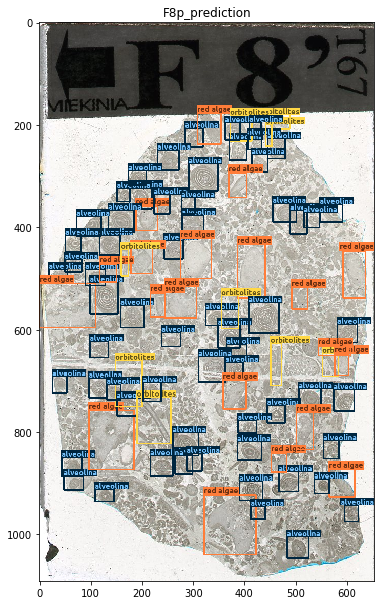

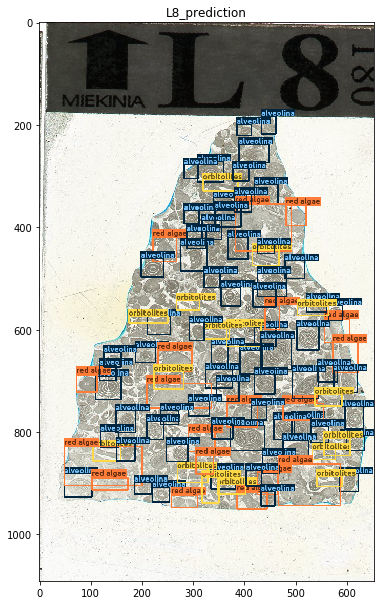

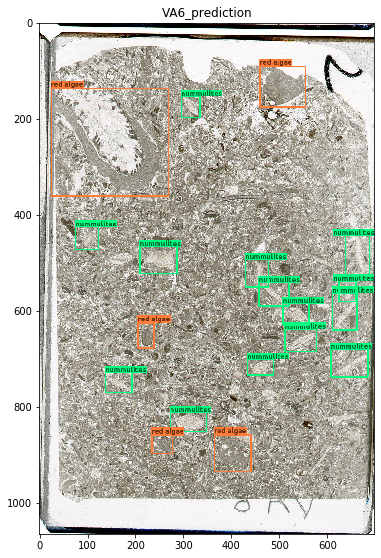

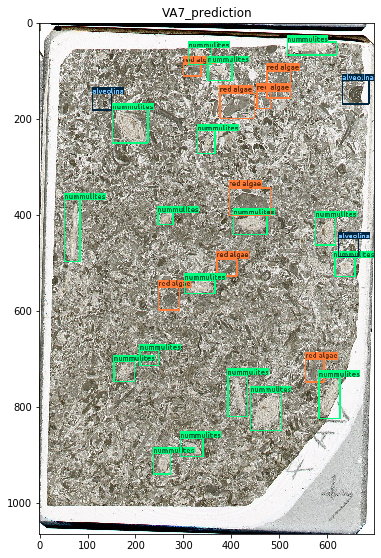

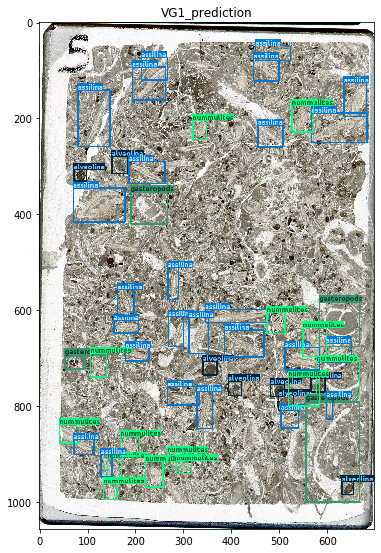

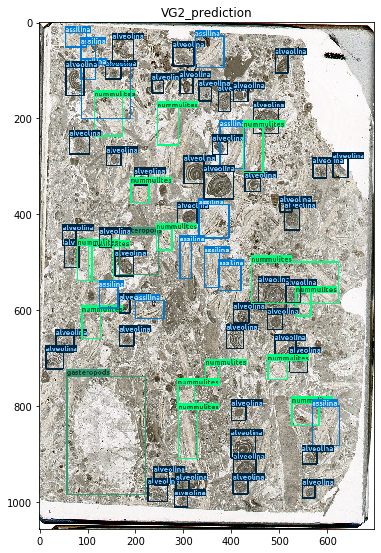

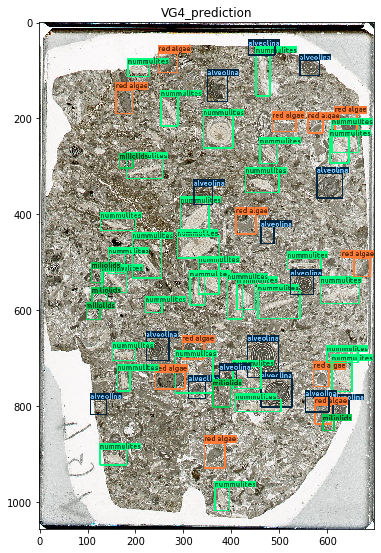

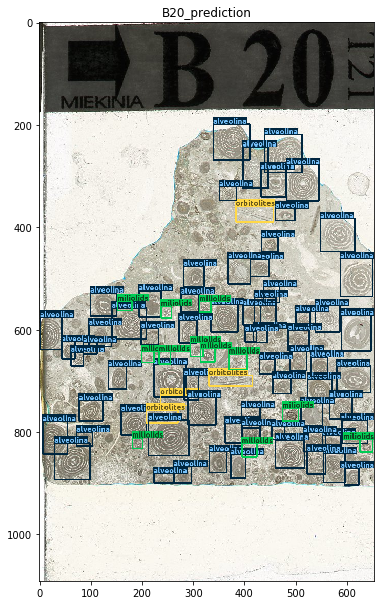

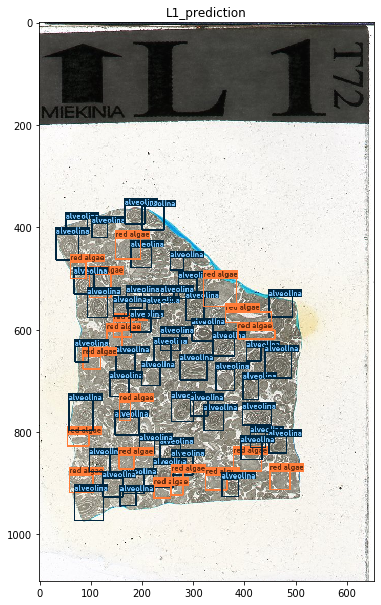

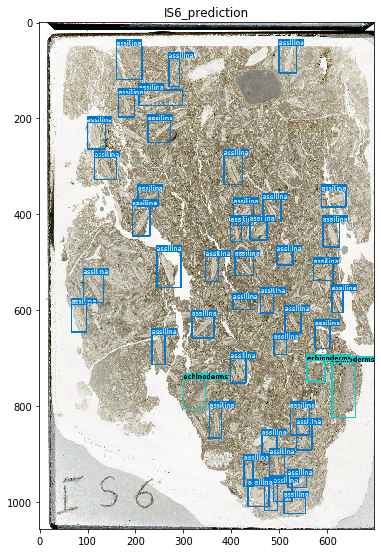

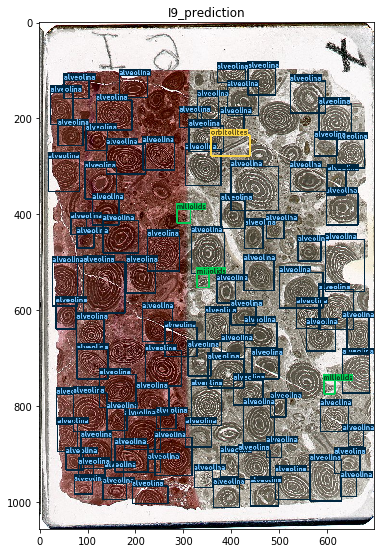

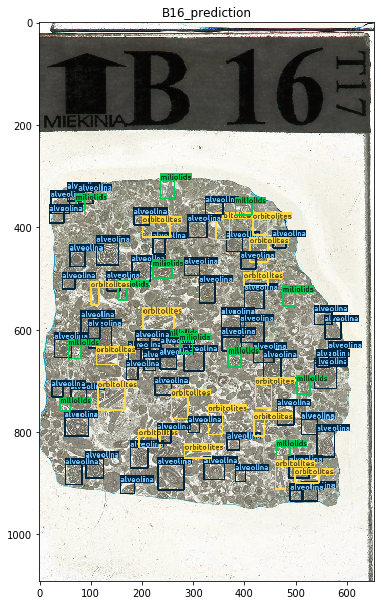

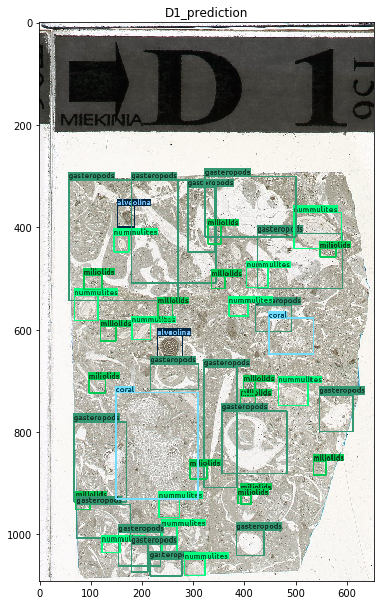

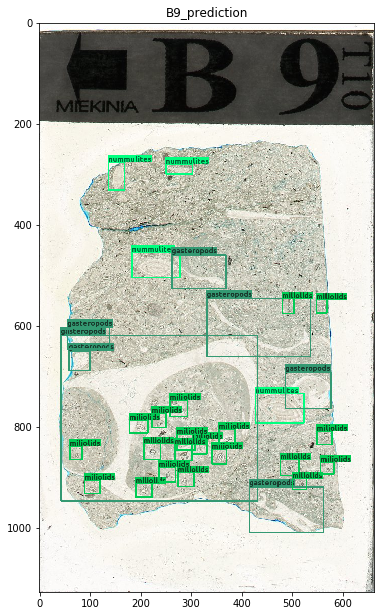

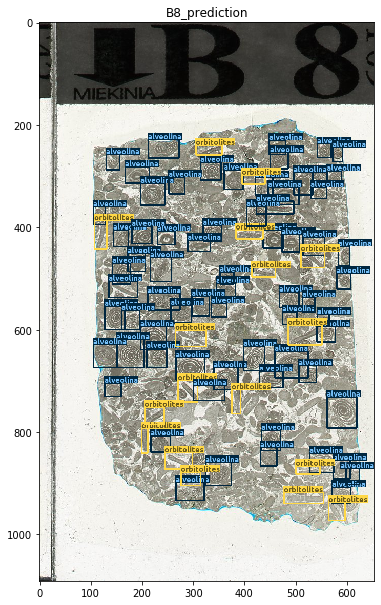

In [66]:
predict_train(save_folder="YOURI/predictions-cascade-rcnn")

In [67]:
def predict_test(input_folder,save_folder):
    print("Prédiction en cours...")
    image_names=os.listdir(input_folder)
    for name in image_names:
        if name== ".ipynb_checkpoints":
            pass
        else:
            image_path=os.path.join(input_folder,name)
            im=cv2.imread(image_path)
            outputs = predictor(im)
            instances=outputs["instances"].to("cpu")
            results=instances.get_fields()
            boxes=results["pred_boxes"]
            boxes=np.array(boxes.tensor)
            scores=results['scores']
            pred_classes=results["pred_classes"]
            for i in range(len(boxes)):
                xmin = int(boxes[i][0])
                ymin = int(boxes[i][1])
                xmax = int(boxes[i][2])
                ymax = int(boxes[i][3])
                color = colors[pred_classes[i]]
                label= training_set.classes[pred_classes[i]]
                bb.add(image=im, left=xmin, top=ymin, right=xmax, bottom=ymax, label=label, color=color)
               
            outpout_name=name[:-4]+"prediction.jpg"
            cv2.imwrite(os.path.join(save_folder,outpout_name), im)
    return True

In [68]:
predict_test(input_folder="YOURI/Scan-Lames",save_folder="YOURI/test-cascade-rcnn")

Prédiction en cours...


True

In [41]:
def visualize_actual_label(save_folder):
    for item in range(len(training_set)):
        d=dataset_dicts[item]
        im = cv2.imread(d["file_name"]) 
        annos=d["annotations"]
        for i in range(len(annos)):
            anno=annos[i]
            xmin = int(anno['bbox'][0])
            ymin = int(anno['bbox'][1])
            xmax = int(anno['bbox'][2])
            ymax = int(anno['bbox'][3])
            color = colors[int(anno["category_id"])]
            label=training_set.classes[int(anno["category_id"])]
            bb.add(image=im, left=xmin, top=ymin, right=xmax, bottom=ymax, label=label, color=color)
        
        name=os.path.split(d["file_name"])[1]
        outpout_name=name[:-4]+"_anno.jpg"
        cv2.imwrite(os.path.join(save_folder,outpout_name), im)
        
    
    return True
          

In [42]:
visualize_actual_label(save_folder = "YOURI/images-anno")

True

In [78]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("foraminifera_val", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "foraminifera_val")
inference_on_dataset(trainer.model, val_loader, evaluator)
#inference_on_dataset(predictor.model, val_loader, evaluator)

[08/05 13:31:25 d2.data.common]: Serializing 15 elements to byte tensors and concatenating them all ...
[08/05 13:31:25 d2.data.common]: Serialized dataset takes 0.07 MiB
[08/05 13:31:25 d2.evaluation.evaluator]: Start inference on 15 images
[08/05 13:31:31 d2.evaluation.evaluator]: Inference done 11/15. 0.2438 s / img. ETA=0:00:01
[08/05 13:31:34 d2.evaluation.evaluator]: Total inference time: 0:00:04.950238 (0.495024 s / img per device, on 1 devices)
[08/05 13:31:34 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (0.259332 s / img per device, on 1 devices)
[08/05 13:31:34 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[08/05 13:31:34 d2.evaluation.coco_evaluation]: Saving results to YOURI/output-mask_rcnn/coco_instances_results.json
[08/05 13:31:34 d2.evaluation.coco_evaluation]: Evaluating predictions ...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation typ

OrderedDict([('bbox',
              {'AP': 88.8363120513138,
               'AP50': 95.59955995599559,
               'AP75': 94.96839164886966,
               'APs': 79.13391291786648,
               'APm': 89.82803593387376,
               'APl': 100.0,
               'AP-alveolina': 83.2494943002541,
               'AP-assilina': 91.17608709133515,
               'AP-coral': 100.0,
               'AP-echinoderms': 100.0,
               'AP-gasteropods': 93.94150991453824,
               'AP-miliolids': 72.41591236771407,
               'AP-nummulites': 94.05313826997977,
               'AP-orbitolites': 75.93278327758065,
               'AP-red algae': 88.7578832404221}),
             ('segm',
              {'AP': 88.00905325577114,
               'AP50': 95.59955995599559,
               'AP75': 94.71742905261003,
               'APs': 79.68811289918327,
               'APm': 89.00157315354681,
               'APl': 98.11606160616061,
               'AP-alveolina': 82.9242873935877

In [27]:
import json
tweets = []
for line in open('output-retinanet/coco_instances_results.json', 'r'):
    tweets.append(json.loads(line))

In [20]:
#tweets

## Anchor boxes with kmeans

In [79]:
class BoundingBox(object):
    def __init__(self,xmin,ymin,xmax,ymax):
        self.xmin=xmin
        self.ymin=ymin
        self.xmax=xmax
        self.ymax=ymax
        self.h=ymax-ymin
        self.w=xmax-xmin

def iou(box1,box2):
    xi_min=max(box1.xmin,box2.xmin)
    yi_min=max(box1.ymin,box2.ymin)
    xi_max=min(box1.xmax,box2.xmax)
    yi_max=min(box1.ymax,box2.xmax)
    inter_width = xi_max-xi_min
    inter_height = yi_max-yi_min
    inter_area = max(0,inter_width)*max(0,inter_height)
    box1_area = box1.h*box1.w
    box2_area = box2.h*box2.w
    union_area = box1_area+box2_area-inter_area
    iou=inter_area/union_area 
    return iou


def distance(box,centroid):
    d=1-iou(box,centroid)
    return d



def update(clusters):
    new_dict=dict()
    for k,v in clusters.items():
        xmin=[v1.xmin for v1 in v]
        ymin=[v1.ymin for v1 in v]
        xmax=[v1.xmax for v1 in v]
        ymax=[v1.ymax for v1 in v]
        b=BoundingBox(np.mean(xmin),np.mean(ymin),np.mean(xmax),np.mean(ymax))
        new_dict[b]=v
    return  new_dict

def kmeans(X,centroids):
    old_clusters={d:[d] for d in centroids}
    old_liste=[len(x) for x in old_clusters.values()]
    old_liste=np.array(old_liste)
    iteration=0
    while True:
        iteration+=1
        new_clusters={d:[d] for d in centroids}

        
        for i in range(len(X)):
            d={centroid:distance(X[i],centroid) for centroid in new_clusters.keys()}
            d_sorted=sorted(d.items(), key = lambda kv:(kv[1]))
            new_clusters[d_sorted[0][0]]=new_clusters[d_sorted[0][0]]+[X[i]]
        new_liste=[len(x) for x in new_clusters.values()]
        new_liste=np.array(new_liste)
       
        if (new_liste==old_liste).all() or iteration>10000:
            break
        else:
            centroids=list(update(new_clusters).keys())
            old_liste=new_liste.copy()
            
    dimension=[(round(centroid.h,0),round(centroid.w,0)) for centroid in centroids]
        
    return centroids,dimension
            

In [80]:
X=[]
for item in range(len(training_set)):
        d=dataset_dicts[item]
        annos=d["annotations"]
        for i in range(len(annos)):
            anno=annos[i]
            xmin = int(anno['bbox'][0])
            ymin = int(anno['bbox'][1])
            xmax = int(anno['bbox'][2])
            ymax = int(anno['bbox'][3])
            X.append(BoundingBox(xmin,ymin,xmax,ymax))
            

In [83]:
%%time
X=np.array(X)
centroids1=X[np.random.choice(len(X),5,replace=False)]
centroids2=X[np.random.choice(len(X),5,replace=False)]
centroids1,dimension1=kmeans(X,centroids1)
centroids2,dimension2=kmeans(X,centroids2)
print("dimension 1=",dimension1)
print("dimension 2=",dimension2)

dimension 1= [(44.0, 45.0), (47.0, 42.0), (49.0, 68.0), (41.0, 45.0), (28.0, 33.0)]
dimension 2= [(44.0, 46.0), (21.0, 27.0), (73.0, 33.0), (32.0, 26.0), (74.0, 32.0)]
CPU times: user 7min 50s, sys: 0 ns, total: 7min 50s
Wall time: 7min 51s


In [119]:
rock_anchors=[(117.0, 135.0), (57.0, 75.0), (58.0, 46.0), (131.0, 144.0), (69.0, 94.0)]

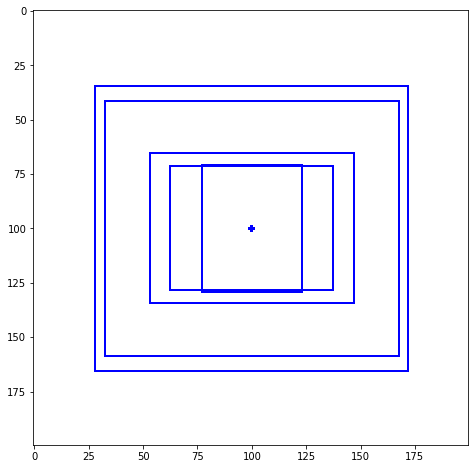

In [121]:
#colors=["red","blue","green","cyan","purple"]
im=255*np.ones((200,200,3))
#plt.figure(figsize=(10,10))
fig,ax=plt.subplots(figsize=(8,8))
for i in range(len(rock_anchors)):
    h,w=rock_anchors[i]
    xc=100
    yc=100
    xmin=xc-w/2
    ymin=yc-h/2
    xmax=xc+w/2
    ymax=yc+h/2
    color=colors[i]
    rect = mpatches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                 fill=False, edgecolor="blue", linewidth=2)
    ax.add_patch(rect)
    cv2.circle(im,(xc,yc),1,(0,0,255),-1)
    
ax.imshow(im.astype('uint8'))
